### Pre-trained networks

- A saved network previously trained on a large scale dataset
- If this dataset is large and general enough
    * Features learned by this pretrained network can act as a generic model
    * Therefore can be used to different computer-vision problems

#### There are two ways to use a pretrained network: feature extraction and fine-tuning

### Feature extraction

- Usage of representations learned by the pretrained network to extract new features from new samples
- Convnet for image classification consist of two parts:
    * The convolutional base, where generic and reusable visual concepts are learned as feature maps.
    * Densely connected layers(classifier) where representations learned are specific to the set of classes the model was trained for 

#### That's why in this case only the conv base will be reused.

Due to the hierarchical nature of representations learned by conv nets, first layers are more reusable, because they learn highly generic concepts such as edges, colors and textures, while end layers learn concepts such as "cat ear" or "dog eye".

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Using TensorFlow backend.


In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### Fast feature extraction without data augmentation

1) Run the convolutional base over your dataset and generates the output feature map of every input

2) Train a densely connected classifier with those output feature map

- Pros:
    * Fast because the convolutional base is ran only once for each image
- Con:
    * For the same reason, it can't be used with data augmentation

In [7]:
import os
base_dir = '../../../newvolume/cat-dog-data/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [4]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [6]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 528us/step - loss: 0.6223 - acc: 0.6515 - val_loss: 0.4557 - val_acc: 0.8250
Epoch 2/30
2000/2000 [==============================] - 1s 312us/step - loss: 0.4449 - acc: 0.7910 - val_loss: 0.3711 - val_acc: 0.8610
Epoch 3/30
2000/2000 [==============================] - 1s 315us/step - loss: 0.3676 - acc: 0.8430 - val_loss: 0.3297 - val_acc: 0.8680
Epoch 4/30
2000/2000 [==============================] - 1s 312us/step - loss: 0.3246 - acc: 0.8600 - val_loss: 0.3050 - val_acc: 0.8780
Epoch 5/30
2000/2000 [==============================] - 1s 310us/step - loss: 0.2905 - acc: 0.8795 - val_loss: 0.2897 - val_acc: 0.8910
Epoch 6/30
2000/2000 [==============================] - 1s 310us/step - loss: 0.2665 - acc: 0.8895 - val_loss: 0.2833 - val_acc: 0.8800
Epoch 7/30
2000/2000 [==============================] - 1s 309us/step - loss: 0.2493 - acc: 0.9015 - val_loss: 0.2736 - val_acc: 0.8830


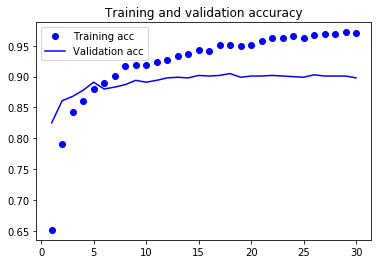

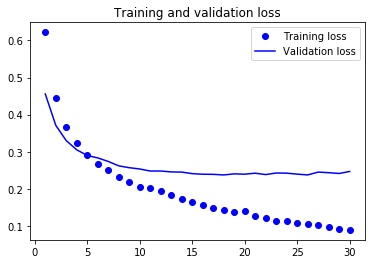

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Feature extraction with data augmentation

Instead of running data only once to extract the output feature maps of each input from the conv base, now the conv base is extended with the densely connected layers and this way allowing data augmentation to be used.

- Pros:
    * end to end execution with conv base, allowing data augmentation
- Con:
    * computationally expensive

In [3]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [5]:
conv_base.trainable = False # freeze layer to not update the weights while training

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 24s 235ms/step - loss: 0.5996 - acc: 0.6845 - val_loss: 0.4576 - val_acc: 0.8220
Epoch 2/30
100/100 [==============================] - 21s 206ms/step - loss: 0.4951 - acc: 0.7680 - val_loss: 0.3741 - val_acc: 0.8630
Epoch 3/30
100/100 [==============================] - 21s 206ms/step - loss: 0.4418 - acc: 0.8020 - val_loss: 0.3434 - val_acc: 0.8580
Epoch 4/30
100/100 [==============================] - 21s 207ms/step - loss: 0.4194 - acc: 0.8160 - val_loss: 0.3132 - val_acc: 0.8790
Epoch 5/30
100/100 [==============================] - 21s 206ms/step - loss: 0.3882 - acc: 0.8315 - val_loss: 0.3021 - val_acc: 0.8780
Epoch 6/30
100/100 [==============================] - 21s 207ms/step - loss: 0.3668 - acc: 0.8430 - val_loss: 0.2941 - val_acc: 0.8760
Epoch 7/30
100/100 [==============================] - 21s 207ms/step - loss: 0.3567 - acc: 0.8390 - val_lo

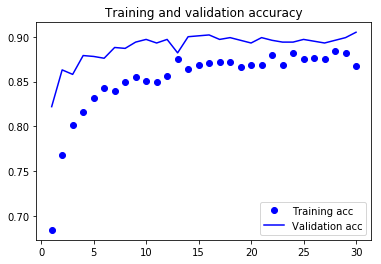

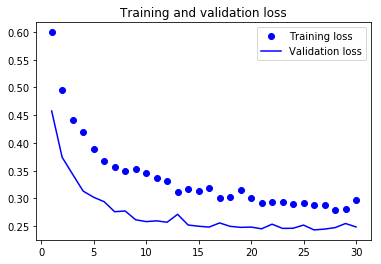

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Fine tuning

Complementary to feature extraction, with fine tuning you unfreeze the last layers of the conv base, where features learned are less generic and train them with an *already trained densely connected classifier*, adjusting them to the new problem at hand.

Why already trained? Because if you allow them to be updated with randomly initialized layers, the error signal propagated through the network is going to be too large and destroy previously learned representations.

In [13]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 24s 241ms/step - loss: 0.2698 - acc: 0.8800 - val_loss: 0.2444 - val_acc: 0.8980
Epoch 2/100
100/100 [==============================] - 23s 230ms/step - loss: 0.2367 - acc: 0.9035 - val_loss: 0.2152 - val_acc: 0.9180
Epoch 3/100
100/100 [==============================] - 23s 231ms/step - loss: 0.2265 - acc: 0.9050 - val_loss: 0.2385 - val_acc: 0.9150
Epoch 4/100
100/100 [==============================] - 23s 231ms/step - loss: 0.2102 - acc: 0.9130 - val_loss: 0.1835 - val_acc: 0.9230
Epoch 5/100
100/100 [==============================] - 23s 232ms/step - loss: 0.2075 - acc: 0.9115 - val_loss: 0.1989 - val_acc: 0.9130
Epoch 6/100
100/100 [==============================] - 23s 233ms/step - loss: 0.1749 - acc: 0.9305 - val_loss: 0.2252 - val_acc: 0.9200
Epoch 7/100
100/100 [==============================] - 23s 233ms/step - loss: 0.1727 - acc: 0.9260 - val_loss: 0.2802 - val_acc: 0.9000
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 23s 232ms/step - loss: 0.0360 - acc: 0.9875 - val_loss: 0.2547 - val_acc: 0.9230
Epoch 62/100
100/100 [==============================] - 23s 232ms/step - loss: 0.0240 - acc: 0.9905 - val_loss: 0.2797 - val_acc: 0.9300
Epoch 63/100
100/100 [==============================] - 23s 231ms/step - loss: 0.0225 - acc: 0.9950 - val_loss: 0.2406 - val_acc: 0.9360
Epoch 64/100
100/100 [==============================] - 23s 232ms/step - loss: 0.0314 - acc: 0.9885 - val_loss: 0.2780 - val_acc: 0.9320
Epoch 65/100
100/100 [==============================] - 23s 232ms/step - loss: 0.0289 - acc: 0.9915 - val_loss: 0.2776 - val_acc: 0.9380
Epoch 66/100
100/100 [==============================] - 23s 231ms/step - loss: 0.0263 - acc: 0.9915 - val_loss: 0.2043 - val_acc: 0.9390
Epoch 67/100
100/100 [==============================] - 23s 232ms/step - loss: 0.0277 - acc: 0.9885 - val_loss: 0.2337 - val_acc: 0.9500
Epoch 68/100
100/100 [===================

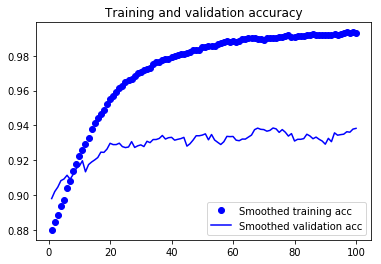

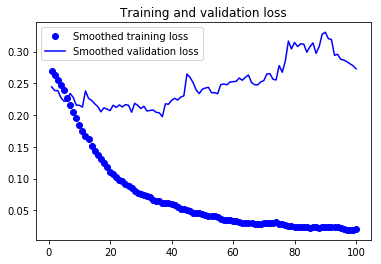

In [18]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9399999964237213
